In [1]:
#https://filterpy.readthedocs.io/en/latest/
try:
    import lcapy
except ModuleNotFoundError:
    print("Could not find lcapy - installing")
    !pip install lcapy
  
from lcapy import Circuit, j, omega, s, exp, sign
from lcapy import R, C, L
from lcapy import *

import numpy as np
from numpy import logspace

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure, savefig

%matplotlib inline

Equivalent Circuit before switch closed at time t=0



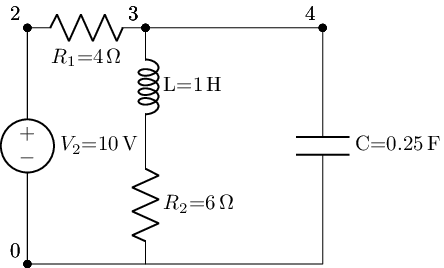



Equivalent Circuit after switch closed at time t=0



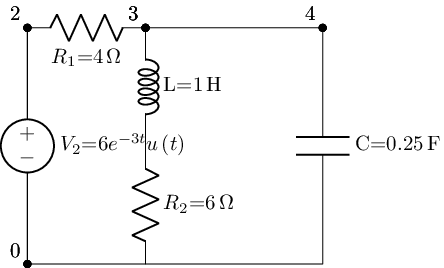

In [15]:
if 1:
    #from sympy import exp, Heaviside, diff

    Vin = 10
    CC = 0.25
    LL = 1

    cct8_0 = Circuit("""
    V2 2 0 dc 10; down
    R1 2 3 4 ; right=1
    L 3 1_3 L ; down=1
    R2 1_3 0_3 6 ; down=1
    W 3 4; right=1.5
    C 4 0_4 C; down=1 
    W 0 0_3; right
    W 0_3 0_4; right
    """)

    cct8_1 = Circuit("""
    V2 2 0 {6*exp(-3*t)*Heaviside(t)}; down
    R1 2 3 4 ; right=1
    L 3 1_3 L ; down=1
    R2 1_3 0_3 6 ; down=1
    W 3 4; right=1.5
    C 4 0_4 C; down=1 
    W 0 0_3; right
    W 0_3 0_4; right
    """)

    cct8_0a = cct8_0.subs({'C':CC, 'L':LL}) # negative time circuit
    cct8_1a = cct8_1.subs({'C':CC, 'L':LL}) # positive time circuit

    # switch networks at time 0
    cct8_1a = cct8_1a.initialize(cct8_0a, 0) 

    print('Equivalent Circuit before switch closed at time t=0\n')
    cct8_0a.draw()
    print('\n\nEquivalent Circuit after switch closed at time t=0\n')
    cct8_1a.draw()

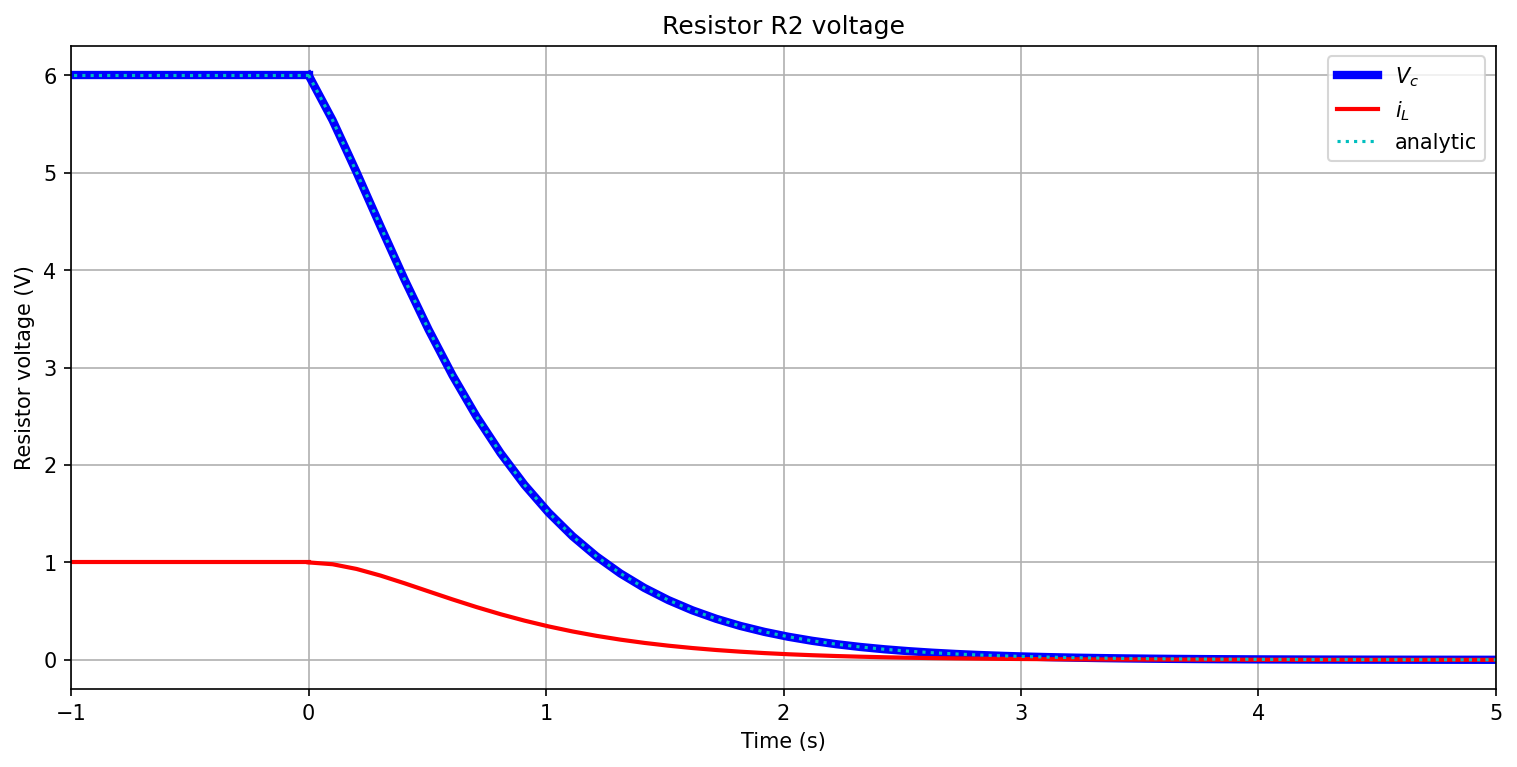

In [19]:
t = np.linspace(0, 10, 100)
tneg = np.linspace(-5, 0, 100)
vc_neg = cct8_0a.C.v.evaluate(tneg)
vc_pos = cct8_1a.C.v.evaluate(t)
ilneg = cct8_0a.L.i.evaluate(tneg)
il = cct8_1a.L.i.evaluate(t)

fig = figure(figsize=(10, 5),dpi=150,constrained_layout = True)
ax = fig.add_subplot(111, title='Resistor R2 voltage')
ax.plot(t, vc_pos, 'b-', linewidth=4, label='$V_c$')
ax.plot(tneg, vc_neg, 'b-', linewidth=4)
ax.plot(tneg, ilneg, linewidth=2, color='red', label='$i_L$')
ax.plot(t, il, linewidth=2, color='red')
ax.plot(t, 44/3*np.exp(-2*t)+np.exp(-5*t)/3-9*np.exp(-3*t), 'c:', label='analytic')
ax.plot(tneg, tneg*0+6, 'c:')
ax.set_xlabel('Time (s)')
ax.set_xlim(-1,5)
ax.set_ylabel('Resistor voltage (V)');
ax.grid()
plt.legend()
plt.show()

In [39]:
from sympy.integrals.transforms import laplace_transform 
from sympy.integrals.transforms import inverse_laplace_transform 
from sympy import * 
import sympy as sympy 
import numpy as np 
from sympy.abc import a, t, x, s, X, g, G 
init_printing(use_unicode=True)

vc, vs, il = symbols('vc vs il', cls = Function) 
vs = 6*sympy.exp(-3*t)*Heaviside(t) 

In [40]:
vc = (44/3*sympy.exp(-2*t) + 1/3*sympy.exp(-5*t) -9*sympy.exp(-3*t))*Heaviside(t) + 6*(1-Heaviside(t))

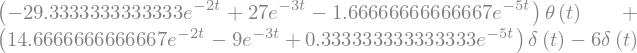

In [41]:
vcdot = vc.diff(t)
vcdot

In [42]:
vcdot0_pos = vcdot.subs(t,0+np.finfo(float).eps) 
vcdot0_pos

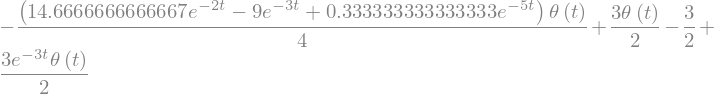

In [55]:
vs/4 - vc/4

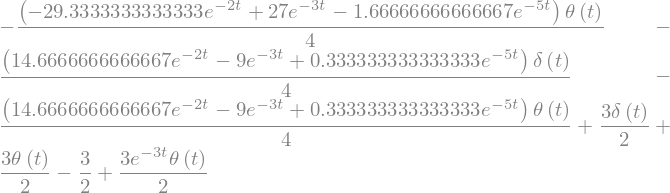

In [56]:
# only valid for pos time
il = vs/4-vcdot/4-vc/4
il

In [57]:
il_pos = il.subs(t,0+np.finfo(float).eps) 
il_pos

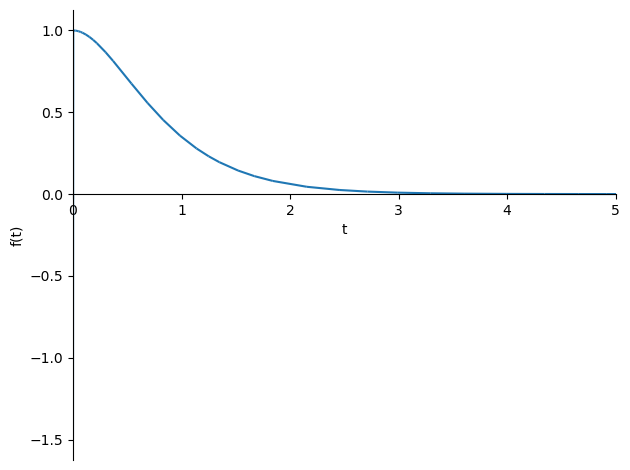

In [59]:
plot(il, xlim=[0,5])
plt.show()